In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from scipy.interpolate import make_interp_spline, BSpline
from us_state_abbrev import us_state_abbrev as abbr

In [4]:
# Read in
urlNYT = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/'
urlAtl = 'https://covidtracking.com/api/v1/states/daily.csv'
urlR0 = 'https://d14wlfuexuxgcm.cloudfront.net/covid/rt.csv'
byState = pd.read_csv(urlNYT+'us-states.csv', index_col='state', parse_dates=['date'])
byCnty = pd.read_csv(urlNYT+'us-counties.csv', index_col='state', parse_dates=['date'])
fullData = pd.read_csv(urlAtl, index_col='state', parse_dates=['date'])
Rnought = pd.read_csv(urlR0, index_col='region', parse_dates=['date'])

In [24]:
s = 'Arkansas'
c = 'Pulaski'

In [25]:
# Subset by state or county
state = byState.loc[s]
county = byCnty.loc[s]
county = county.reset_index().set_index('county')
county = county.loc[c]
historic = fullData.loc[abbr[s]]
Re = Rnought.loc[abbr[s]]

In [26]:
# Add new cases
state = state.reset_index().set_index('date')
county = county.reset_index().set_index('date')
historic = historic.reset_index().set_index('date')
state['newCases'] = state.cases.diff()
for cnty, data in county.groupby('county'):
    county.loc[county['county']==cnty, 'newCases'] = data.cases.transform('diff')

In [49]:
# Calculate ratio of positive cases each day: total positive/total tests
dailyPercent = historic.positiveIncrease/historic.totalTestResultsIncrease

# Sort from earliest to latest date, remove NAs produced from divide by zero and leading NAs
dailyPercent = dailyPercent[::-1].dropna()

In [50]:
# Replace inf, -inf with 0
dailyPercent.replace({-np.inf: 0, np.inf: 0}, inplace=True)

In [51]:
# Smooth plot: interpolate to 1-hourly
newTimes = pd.date_range(dailyPercent.index[0], dailyPercent.index[-1], freq='1H')
spl = make_interp_spline(dailyPercent.index, dailyPercent, k=3)  # type: BSpline
dailyPercentSmooth = pd.Series(spl(newTimes), index=newTimes)

In [52]:
# Calculate ratio of total number of cases
totalPercent = historic.positive/historic.totalTestResults

# Sort from earliest to latest date, remove NAs produced from divide by zero and leading NAs
totalPercent = totalPercent[::-1].dropna()

In [53]:
# Smooth plot: interpolate to 1-hourly
spl = make_interp_spline(totalPercent.index, totalPercent, k=3)  # type: BSpline
totalPercentSmooth = pd.Series(spl(newTimes), index=newTimes)

In [54]:
def add_r0(fontsize=11):
    # Conditional coloring for prediction bar
    def color():
        return 'darkgreen' if re < 1 else 'darkred'
    # Legend location
    p = leg.get_window_extent()
    re = np.round(Re['mean'].iloc[-1], 3)
    ax.annotate('Effective reproduction', (p.p0[0]-90, p.p1[1]-75), (p.p0[0]-90, p.p1[1]-75),
                xycoords='figure pixels', fontsize=fontsize)
    ax.annotate(r'number, $r_e$:', (p.p0[0]-90, p.p1[1]-90), (p.p0[0]-90, p.p1[1]-90), 
                xycoords='figure pixels', fontsize=fontsize)
    ax.annotate(re, (p.p0[0]-20, p.p1[1]-90), (p.p0[0]-20, p.p1[1]-90), 
                xycoords='figure pixels', fontsize=fontsize+1,
                color=color())

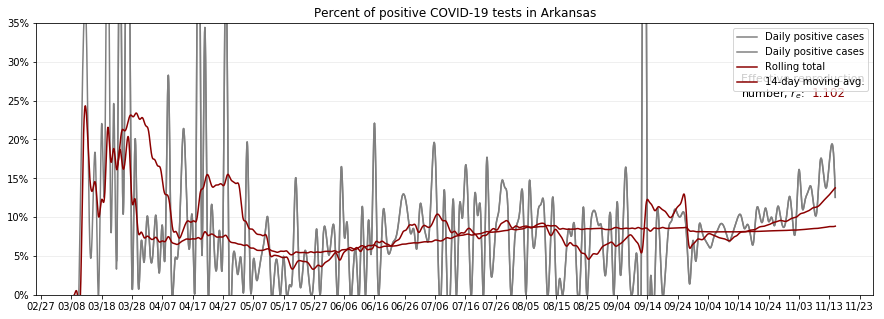

In [55]:
firstDate = totalPercentSmooth.index[0] + pd.Timedelta(days=14)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dailyPercentSmooth.loc[firstDate:], label='Daily positive cases', color='grey')
ax.plot(dailyPercentSmooth, label='Daily positive cases', color='grey')
ax.plot(totalPercentSmooth, label='Rolling total', color='darkred')
ax.plot(dailyPercentSmooth.rolling(14*24).mean(), color='darkred', label='14-day moving avg.')
ax.set_title('Percent of positive COVID-19 tests in {}'.format(s))
leg = ax.legend(loc='upper right')
plt.draw()
add_r0()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.set_ylim(0, 0.35)
ax.grid(axis='y', alpha=0.25)
plt.show()

In [20]:
# Total daily test counts
normalized = state.newCases/historic.totalTestResultsIncrease
normalized.replace([np.inf, -np.inf], np.nan, inplace=True)
normalized = normalized.interpolate().dropna()
firstDate = normalized.index[0] + pd.Timedelta(days=14)

In [21]:
spl = make_interp_spline(normalized.index, normalized)  # type: BSpline
normalizedSmooth = pd.Series(spl(newTimes), index=newTimes)

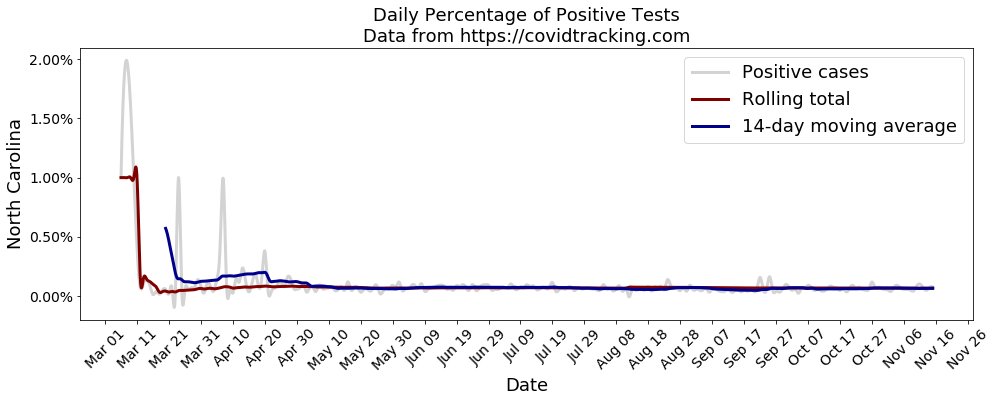

In [22]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.plot(dailyPercentSmooth, linewidth=3, color='lightgrey', 
        label='Positive cases')
ax.plot(totalPercentSmooth, linewidth=3, color='maroon',
        label='Rolling total')
ax.plot(dailyPercentSmooth.rolling(14*24).mean(), linewidth=3, color='darkblue',
        label='14-day moving average')
ax.set_title('Daily Percentage of Positive Tests\n'\
              'Data from https://covidtracking.com',
              fontsize=18)
ax.tick_params(axis='x', labelsize=14, labelrotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(s, fontsize=18)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='upper right', fontsize=18)
plt.show()

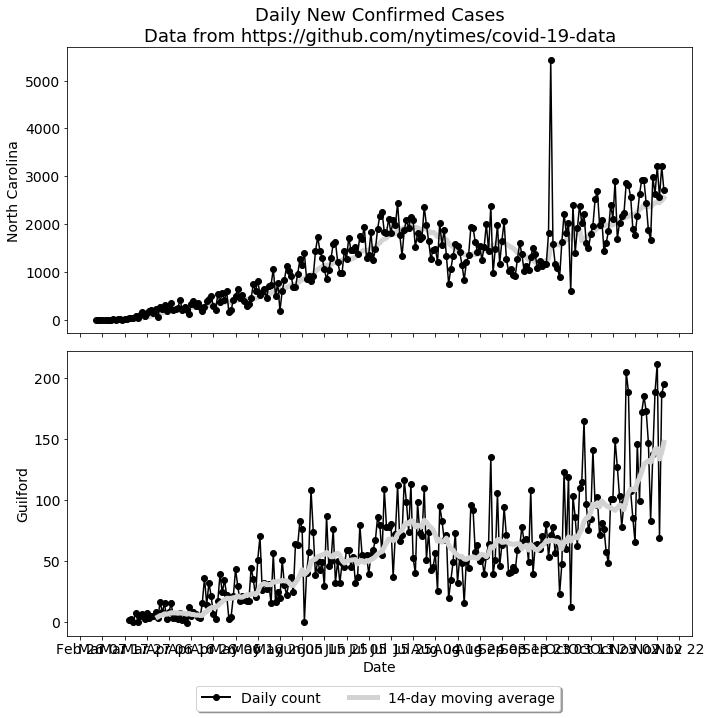

In [23]:
# Make plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax1.plot(state['newCases'], '-o', label='Daily positive count', color='black', zorder=1)
ax1.plot(state['newCases'].rolling(14).mean(), label='14-day moving average', color='lightgrey', linewidth=5, zorder=0)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylabel(s, fontsize=14)
ax1.set_title('Daily New Confirmed Cases\nData from https://github.com/nytimes/covid-19-data', fontsize=18)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax2.plot(county['newCases'], '-o', label='Daily count', color='black')
ax2.plot(county['newCases'].rolling(14).mean(), label='14-day moving average', color='lightgrey', linewidth=5)
ax2.set_xlabel('Date', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel(c, fontsize=14)
ax2.legend(loc='best', fontsize=14)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

custom_lines = [plt.Line2D([0],[0], linestyle='solid', lw=2,
                           color='black', marker='o'),
                plt.Line2D([0],[0], linestyle='solid', lw=5,
                           color='lightgrey')]
ax2.legend(custom_lines, ['Daily count', '14-day moving average'],
           ncol=2, fontsize=14, bbox_to_anchor=(0.8, -0.15),
           edgecolor='lightgrey', fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

In [22]:
from us_state_abbrev import us_state_abbrev as abbr

In [23]:
regions = [('Florida', 'Miami-Dade'),
           ('Delaware', 'Sussex'),
           ('Connecticut', 'Litchfield'),
           ('Massachusetts', 'Plymouth'),
           ('Michigan', 'Midland')]

In [26]:
for s, c in regions:
    print('{} County in {} ({})'.format(c, s, abbr[s]))

Miami-Dade County in Florida (FL)
Sussex County in Delaware (DE)
Litchfield County in Connecticut (CT)
Plymouth County in Massachusetts (MA)
Midland County in Michigan (MI)
